<a href="https://colab.research.google.com/github/scottspurlock/csc401-2021s/blob/main/tutorials/day09_tutorial_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 9 Tutorial: Decision Trees & Random Forests
Adapted from VanderPlas

So far, we've seen two classifiers:
- K-nearest neighbors
- Naive Bayes

Next we'll look at decision trees and random forests.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Read in the data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1jsazLeOrMKG4IJJ6-KpoGmxUdex6qPoJ")
df = df.dropna()
print(df.shape)
df

(15, 8)


,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,non-mammals
2,salmon,0,0,1,0,0,0,non-mammals
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,non-mammals
5,komodo,0,0,0,0,1,0,non-mammals
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,non-mammals
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,non-mammals


## Training a decision tree model
As shown below, training a decision tree classifier works the same as other models we've worked with using scikit learn: make a classifier object (in this case called clf) specifying any hyperparameters, then fit the model using the training data and labels (Xtrain and ytrain).

In [3]:
# Import the library
from sklearn.tree import DecisionTreeClassifier

ytrain = df['Class']
Xtrain = df.drop(['Name','Class'], axis=1)


# Make a tree object using entropy to decide splits
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)

# Fit a model to the training data
# (or, learn the decision tree)
clf = clf.fit(Xtrain, ytrain)

## Visualization
One of the best aspects of decision trees is that they are intuitive to understand and visualize.

A decision tree classifies examples by making a series of choices based on the attributes. For example: "does this animal give live birth?" or "is it warm-blooded?"

In the graph below, notice that how blue or orange a node is corresponds to how "mixed up" the labels are at that point in the tree. The bottom nodes are called leaf nodes, and they consist purely of one class or the other.

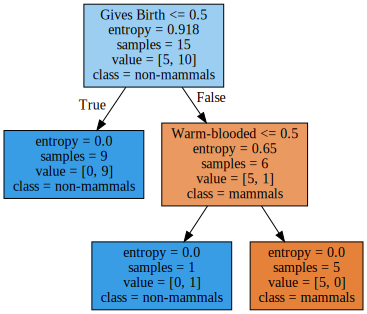

In [4]:
from sklearn.tree import export_graphviz
import graphviz

vis_data = export_graphviz(clf, out_file=None,
                feature_names=Xtrain.columns,
                class_names=clf.classes_,
                filled=True)

graph = graphviz.Source(vis_data) 
graph

## Entropy
During training, the decision tree algorithm decides the best sequence of attributes to put in the tree based on entropy, a measure of how "mixed up" the labels of the examples are.

For example, when half the labels are one thing (e.g., mammals) and half are something else (e.g., non-mammals), the entropy is 1, its max value when there are 2 classes. When the labels are all one class or the other, then entropy is 0. (When there are more than 2 classes, the max entropy can be higher than 1.)

In [5]:
from scipy.stats import entropy

print(entropy([1/2, 1/2], base=2))
print(entropy([0, 1], base=2))
print(entropy([1, 0], base=2))


1.0
0.0
0.0


We can make a graph of how mixed up a set of labels is vs entropy.

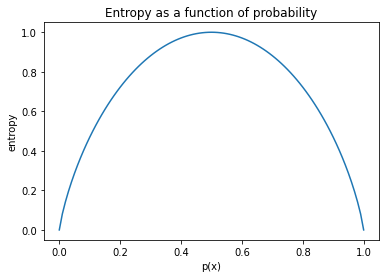

In [6]:
p_x = np.arange(0, 1.01, 0.01)
ent = np.zeros_like(p_x)
for i, p in enumerate(p_x):
  ent[i] = entropy([p, 1-p], base=2)

plt.plot(p_x, ent)
plt.xlabel('p(x)')
plt.ylabel('entropy')
plt.title('Entropy as a function of probability')
plt.show()

## Visualizations
The following scatter plot visualizations are adapted from VanderPlas.

Consider the following two-dimensional data, which has one of four class labels:

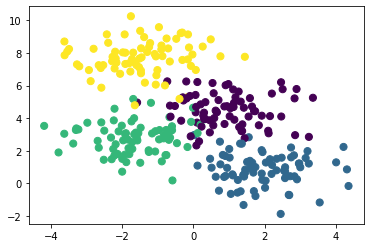

In [7]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis');

The following section contains some visualization code from VanderPlas. It's just to illustrate things in this tutorial, so no need to use it in future work or completely understand all the details unless you just want to.

In [8]:
#@title
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            if hasattr(estimator, 'tree_'):
              tree = estimator.tree_
          
              if tree.feature[i] == 0:
                  ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                  plot_boundaries(tree.children_left[i],
                                  [xlim[0], tree.threshold[i]], ylim)
                  plot_boundaries(tree.children_right[i],
                                  [tree.threshold[i], xlim[1]], ylim)
          
              elif tree.feature[i] == 1:
                  ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                  plot_boundaries(tree.children_left[i], xlim,
                                  [ylim[0], tree.threshold[i]])
                  plot_boundaries(tree.children_right[i], xlim,
                                  [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. This figure presents a visualization of the first four levels of a decision tree classifier for this data:

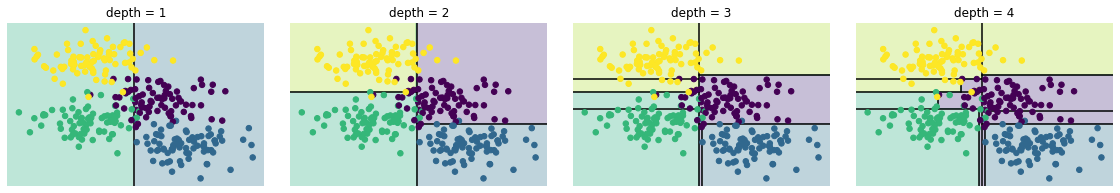

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

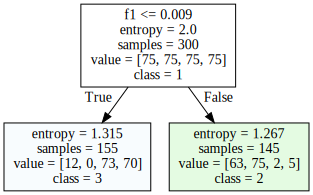

In [10]:
depth = 1

model = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
model.fit(X, y)

vis_data = export_graphviz(model, out_file=None,
                feature_names=['f1', 'f2'],
                class_names=['1', '2', '3', '4'],
                filled=True)

graph = graphviz.Source(vis_data) 
graph

## Overfitting
Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a skinny green region within the purple region. It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data. That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

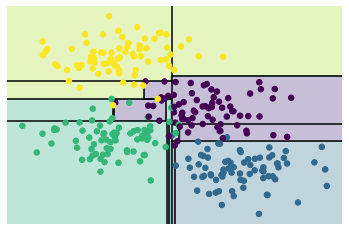

In [11]:
model = DecisionTreeClassifier(max_depth=5, criterion='entropy')
visualize_tree(model, X, y)

Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from. Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

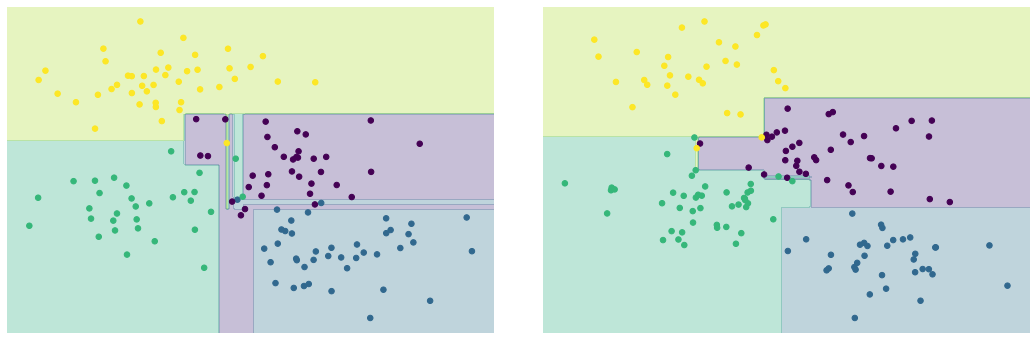

In [12]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])


It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters). The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from both of these trees, we might come up with a better result!

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

In Scikit-Learn, the ``RandomForestClassifier`` handles all the details of randomly selecting subsets of attibutes and samples of training data to train multiple trees and aggregate their predictions. All you need to do is select a number of estimators, and it will fit the ensemble of trees:

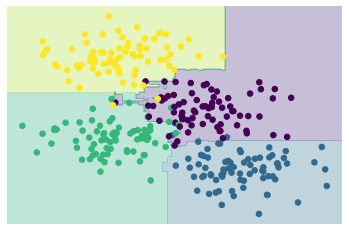

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Create a model
model = RandomForestClassifier(n_estimators=10, random_state=0, criterion='entropy')

# Normally the next step would be to fit the model and test it.
# For tutorial purposes, we'll just do some visualization.
visualize_tree(model, X, y);

We see that by averaging over multiple randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the feature space should be split.

## Summary of Random Forests

This tutorial contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the ``predict_proba()`` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

One note is that while an individual decision tree is (at least somewhat) human readable, a primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.